# Clustering Case Study: Customer Segmentation with K-Means -  Tier 3
***
This case study is based on [this blog post](http://blog.yhat.com/posts/customer-segmentation-using-python.html) by the `yhat` blog. Please feel free to refer to the post for additional information, and solutions.

Structure of the mini-project:

1. **Sourcing and loading**
    * Load the data
    * Explore the data


2. **Cleaning, transforming and visualizing**
    * Data Wrangling: Exercise Set 1
        - Creating a matrix with a binary indicator for whether they responded to a given offer
        - Ensure that in doing so, NAN values are dealt with appropriately
    

3. **Modelling** 
    * K-Means clustering: Exercise Sets 2 and 3
        - Choosing K: The Elbow method
        - Choosing K: The Silhouette method
        - Choosing K: The Gap statistic method
    
    * Visualizing clusters with PCA: Exercise Sets 4 and 5


4. **Conclusions and next steps**
    * Conclusions
    * Other clustering algorithms (Exercise Set 6)

In [1]:
%matplotlib inline
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

## 1. Sourcing and loading
### 1a. Load the data
The dataset contains information on marketing newsletters/e-mail campaigns (e-mail offers sent to customers) and transaction level data from customers. The transactional data shows which offer customers responded to, and what the customer ended up buying. The data is presented as an Excel workbook containing two worksheets. Each worksheet contains a different dataset.

In [2]:
df_offers = pd.read_excel("./WineKMC.xlsx", sheet_name=0)

### 1b. Explore the data

In [3]:
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
df_offers.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True


We see that the first dataset contains information about each offer such as the month it is in effect and several attributes about the wine that the offer refers to: the variety, minimum quantity, discount, country of origin and whether or not it is past peak. The second dataset in the second worksheet contains transactional data -- which offer each customer responded to.

In [4]:
df_transactions = pd.read_excel("./WineKMC.xlsx", sheet_name=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1
df_transactions.head()

,customer_name,offer_id,n
0,Smith,2,1
1,Smith,24,1
2,Johnson,17,1
3,Johnson,24,1
4,Johnson,26,1


In [5]:
df_offers.shape, df_transactions.shape

((32, 7), (324, 3))

## 2. Cleaning, transforming and visualizing
### 2a. Data Wrangling

We're trying to learn more about how our customers behave, so we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set I</h3>

<p><b>Exercise:</b> Create a data frame where each row has the following columns (Use the pandas [`merge`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) and [`pivot_table`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html) functions for this purpose):
<ul>
<li> customer_name
<li> One column for each offer, with a 1 if the customer responded to the offer
</ul>
<p>Make sure you also deal with any weird values such as `NaN`. Read the documentation to develop your solution.</p>
</div>

In [9]:
# Let's check for missing data
print(df_offers.isnull().sum())
print(df_transactions.isnull().sum())

offer_id     0
campaign     0
varietal     0
min_qty      0
discount     0
origin       0
past_peak    0
dtype: int64
customer_name    0
offer_id         0
n                0
dtype: int64


In [12]:
# No null values, but let's check to make sure data looks ok generally
df_offers.info(), df_transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   offer_id   32 non-null     int64 
 1   campaign   32 non-null     object
 2   varietal   32 non-null     object
 3   min_qty    32 non-null     int64 
 4   discount   32 non-null     int64 
 5   origin     32 non-null     object
 6   past_peak  32 non-null     bool  
dtypes: bool(1), int64(3), object(3)
memory usage: 1.7+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 324 entries, 0 to 323
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customer_name  324 non-null    object
 1   offer_id       324 non-null    int64 
 2   n              324 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 7.7+ KB


(None, None)

In [13]:
# Let's make sure we don't have any zero values where we don't expect them
df_offers.describe(), df_transactions.describe()

(        offer_id     min_qty   discount
 count  32.000000   32.000000  32.000000
 mean   16.500000   65.812500  57.843750
 std     9.380832   50.785722  20.770807
 min     1.000000    6.000000  17.000000
 25%     8.750000   12.000000  44.750000
 50%    16.500000   72.000000  55.000000
 75%    24.250000   72.000000  82.250000
 max    32.000000  144.000000  89.000000,
          offer_id      n
 count  324.000000  324.0
 mean    17.012346    1.0
 std      9.703332    0.0
 min      1.000000    1.0
 25%      8.000000    1.0
 50%     18.000000    1.0
 75%     26.000000    1.0
 max     32.000000    1.0)

In [17]:
# Let's make sure campaign, varietal, origin values look good
df_offers.campaign.value_counts(), df_offers.varietal.value_counts(), df_offers.origin.value_counts(), df_offers.past_peak.value_counts()

(May          3
 June         3
 March        3
 December     3
 October      3
 July         3
 February     3
 August       3
 January      2
 November     2
 April        2
 September    2
 Name: campaign, dtype: int64,
 Champagne             7
 Cabernet Sauvignon    6
 Pinot Noir            4
 Prosecco              4
 Espumante             3
 Merlot                3
 Malbec                2
 Chardonnay            2
 Pinot Grigio          1
 Name: varietal, dtype: int64,
 France          9
 Chile           4
 Germany         3
 California      3
 Italy           3
 Australia       3
 Oregon          3
 New Zealand     2
 South Africa    2
 Name: origin, dtype: int64,
 False    25
 True      7
 Name: past_peak, dtype: int64)

Data looks very clean.  We don't seem to have any missing values, nor do we have data that needs to be cleaned up.    

In [52]:
# Let's create our matrix.  We want 33 columns, one for customer name and 32 for each offer, with a 1 or 0 indicating
# whether customer responded to each offer. 
# We want to make sure every offer is in the transaction table
# Let's see how many unique customers we have
df_transactions.customer_name.nunique(), df_offers.offer_id.nunique()

(100, 32)

In [219]:
df_cust_by_offer = df_transactions.pivot(index='customer_name', columns='offer_id', values='n')
df_cust_by_offer.fillna(0, inplace=True)
df_cust_by_offer = df_cust_by_offer.astype(int)

In [220]:
df_cust_by_offer

offer_id,1,2,3,4,5,6,7,8,9,10,...,23,24,25,26,27,28,29,30,31,32
customer_name,,,,,,,,,,,,,,,,,,,,,
Adams,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
Allen,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
Anderson,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
Bailey,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
Baker,0,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Williams,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
Wilson,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
Wood,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0


## 3. Modelling 
### 3a. K-Means Clustering

Recall that in K-Means Clustering we want to *maximize* the distance between centroids and *minimize* the distance between data points and the respective centroid for the cluster they are in. True evaluation for unsupervised learning would require labeled data; however, we can use a variety of intuitive metrics to try to pick the number of clusters K. We will introduce two methods: the Elbow method, the Silhouette method and the gap statistic.

#### 3ai. Choosing K: The Elbow Sum-of-Squares Method

The first method looks at the sum-of-squares error in each cluster against $K$. We compute the distance from each data point to the center of the cluster (centroid) to which the data point was assigned. 

$$SS = \sum_k \sum_{x_i \in C_k} \sum_{x_j \in C_k} \left( x_i - x_j \right)^2 = \sum_k \sum_{x_i \in C_k} \left( x_i - \mu_k \right)^2$$

where $x_i$ is a point, $C_k$ represents cluster $k$ and $\mu_k$ is the centroid for cluster $k$. We can plot SS vs. $K$ and choose the *elbow point* in the plot as the best value for $K$. The elbow point is the point at which the plot starts descending much more slowly. 

**Hint:** the Elbow Method is discussed in part 2 of the Harvard Clustering lecture. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set II</h3>

<p><b>Exercise:</b></p> 
<ul>
<li> What values of $SS$ do you believe represent better clusterings? Why?
<li> Create a numpy matrix `x_cols` with only the columns representing the offers (i.e. the 0/1 colums) 
<li> Write code that applies the [`KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering method from scikit-learn to this matrix. 
<li> Construct a plot showing $SS$ for each $K$ and pick $K$ using this plot. For simplicity, test $2 \le K \le 10$.
<li> Make a bar chart showing the number of points in each cluster for k-means under the best $K$.
<li> What challenges did you experience using the Elbow method to pick $K$?
</ul>
</div>

In [310]:
# Import KMeans
from sklearn.cluster import KMeans

# Reset the index on df_cust_by_offer and drop the customer_name so we have just 1's and 0's indexed by a range
X = df_cust_by_offer.reset_index().drop(columns='customer_name')

# initialize an empty list to hold the values of sum of squares for each k
SS=[]

# Create a for loop for our values of k
for k in range(2,11):
    
    # create k clusters
    kmeans = KMeans(n_clusters=k, random_state=10)
    clusters = pd.DataFrame(kmeans.fit_predict(X), columns=['Cluster'])
    centers = kmeans.cluster_centers_

    SS_k=0
    
    # for each cluster sum the square of distance between each instance in the cluster and the cluster centroid
    for i in range(k):
        SS_k += np.sum(X[clusters['Cluster']==i].apply(lambda x:np.sum((x-centers[i])**2), axis=1))

    # append the total sum of squares to our list
    SS.append(SS_k)

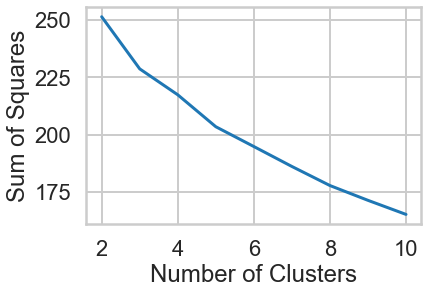

In [311]:
# Plot SS vs k
sns.set_style()
plt.plot(range(2,11),SS)
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squares');

It's not at all clear where the "elbow" is for this graph.  For this case we will pick k=4 as our optimum number of clusters.  Let's create those clusters and then look at how many instances are in each cluster.

In [312]:
kmeans = KMeans(n_clusters=4)
clusters = pd.DataFrame(kmeans.fit_predict(X), columns=['Cluster'])
clusters['count']=0
num_inst_per_cluster = clusters.groupby('Cluster').count()

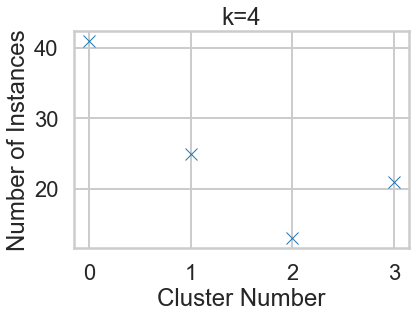

In [313]:
plt.plot(num_inst_per_cluster, linestyle="None", marker='x')
plt.xlabel('Cluster Number')
plt.ylabel('Number of Instances')
plt.title('k=4');

#### 3aii. Choosing K: The Silhouette Method

There exists another method that measures how well each datapoint $x_i$ "fits" its assigned cluster *and also* how poorly it fits into other clusters. This is a different way of looking at the same objective. Denote $a_{x_i}$ as the *average* distance from $x_i$ to all other points within its own cluster $k$. The lower the value, the better. On the other hand $b_{x_i}$ is the minimum average distance from $x_i$ to points in a different cluster, minimized over clusters. That is, compute separately for each cluster the average distance from $x_i$ to the points within that cluster, and then take the minimum. The silhouette $s(x_i)$ is defined as

$$s(x_i) = \frac{b_{x_i} - a_{x_i}}{\max{\left( a_{x_i}, b_{x_i}\right)}}$$

The silhouette score is computed on *every datapoint in every cluster*. The silhouette score ranges from -1 (a poor clustering) to +1 (a very dense clustering) with 0 denoting the situation where clusters overlap. Some criteria for the silhouette coefficient is provided in the table below.

<pre>

| Range       | Interpretation                                |
|-------------|-----------------------------------------------|
| 0.71 - 1.0  | A strong structure has been found.            |
| 0.51 - 0.7  | A reasonable structure has been found.        |
| 0.26 - 0.5  | The structure is weak and could be artificial.|
| < 0.25      | No substantial structure has been found.      |

</pre>
Source: http://www.stat.berkeley.edu/~spector/s133/Clus.html

**Hint**: Scikit-learn provides a function to compute this for us (phew!) called [`sklearn.metrics.silhouette_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html). Take a look at [this article](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) on picking $K$ in scikit-learn, as it will help you in the next exercise set.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set III</h3>

<p><b>Exercise:</b> Using the documentation for the `silhouette_score` function above, construct a series of silhouette plots like the ones in the article linked above.</p>

<p><b>Exercise:</b> Compute the average silhouette score for each $K$ and plot it. What $K$ does the plot suggest we should choose? Does it differ from what we found using the Elbow method?</p>
</div>

For n_clusters = 2 The average silhouette_score is : 0.07926723462002187
For n_clusters = 3 The average silhouette_score is : 0.12088714398658584
For n_clusters = 4 The average silhouette_score is : 0.12070876648807144
For n_clusters = 5 The average silhouette_score is : 0.11678119134977846
For n_clusters = 6 The average silhouette_score is : 0.11000874527291185
For n_clusters = 7 The average silhouette_score is : 0.10697456031659204
For n_clusters = 8 The average silhouette_score is : 0.10397130938289348
For n_clusters = 9 The average silhouette_score is : 0.1093456369328584
For n_clusters = 10 The average silhouette_score is : 0.11531511028579436


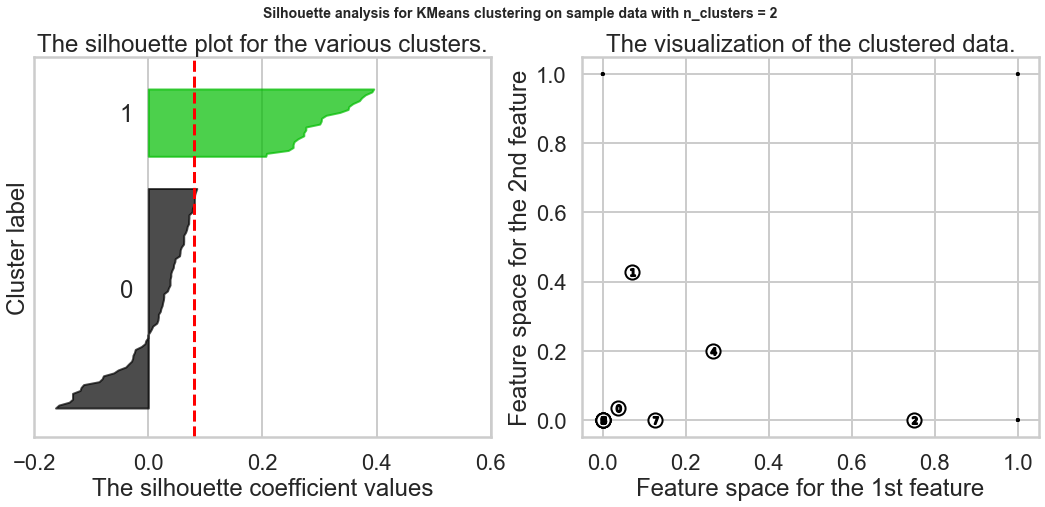

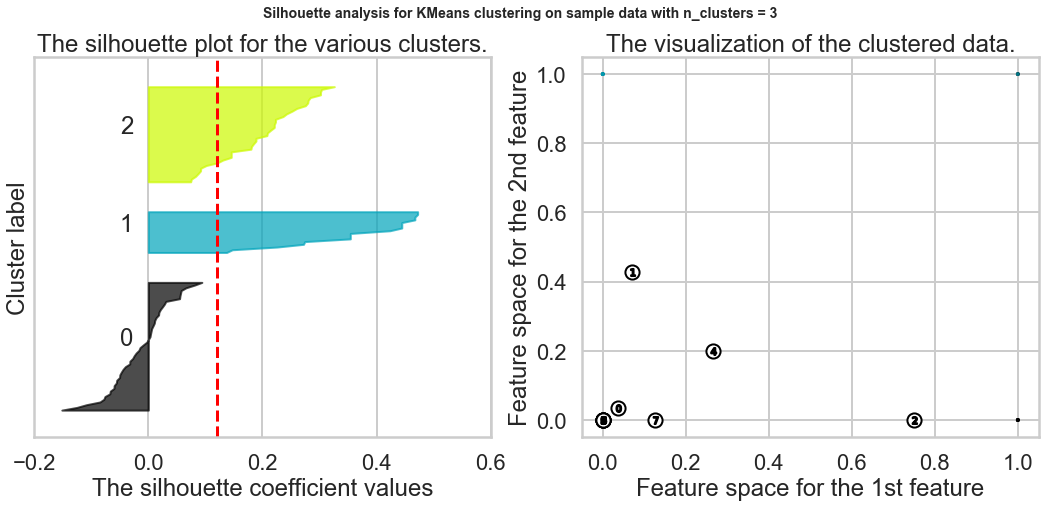

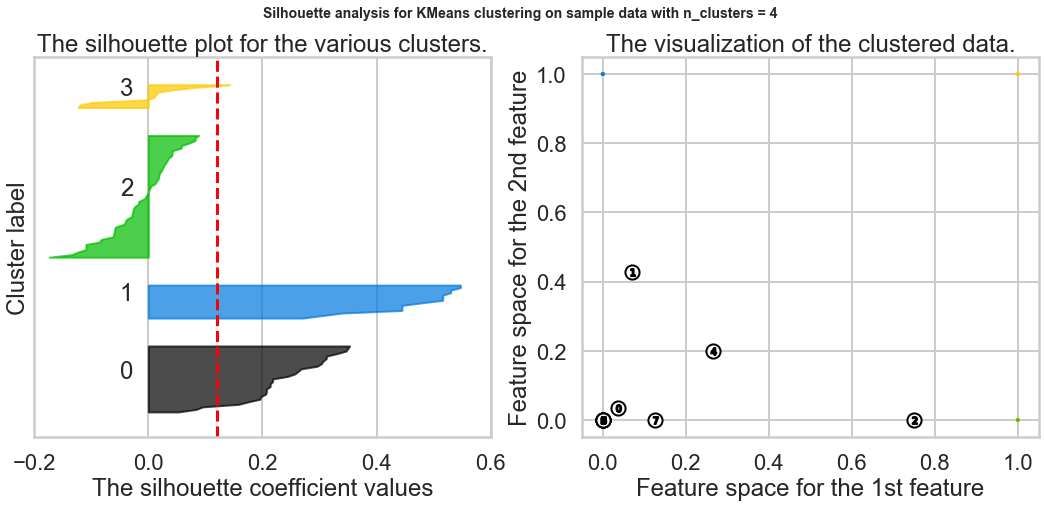

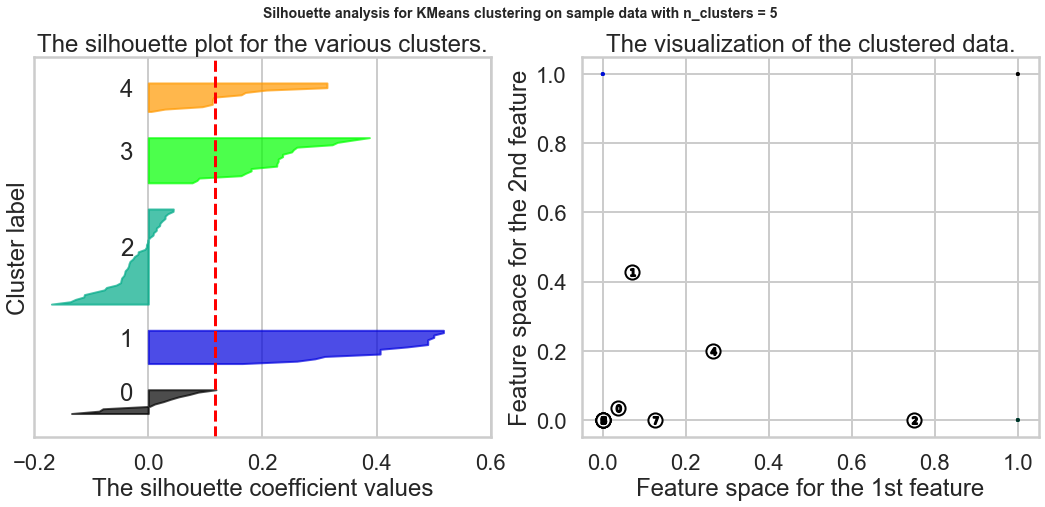

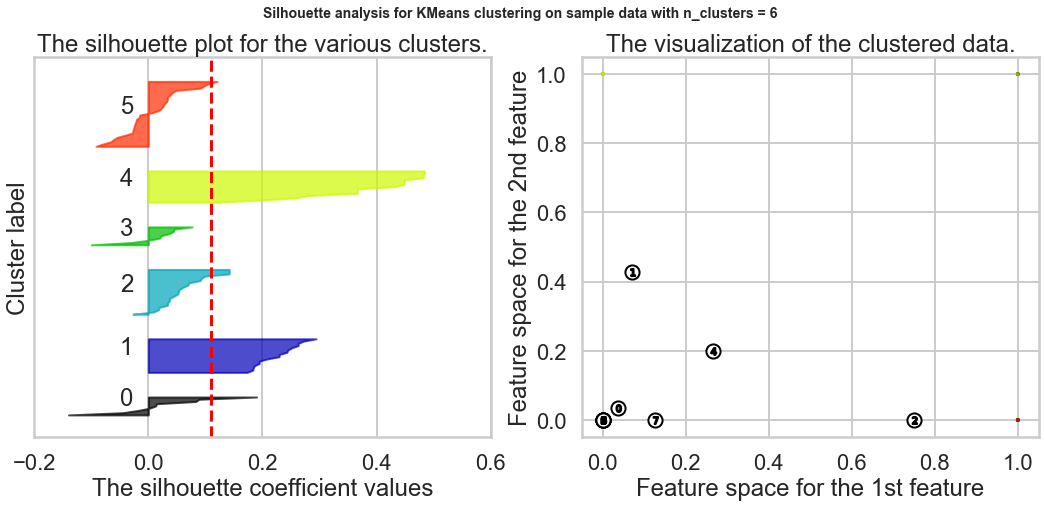

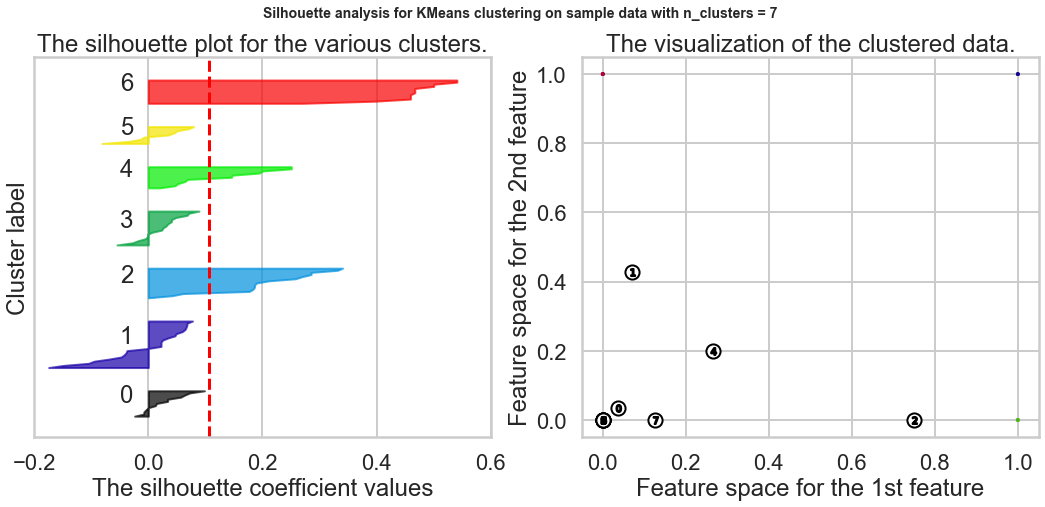

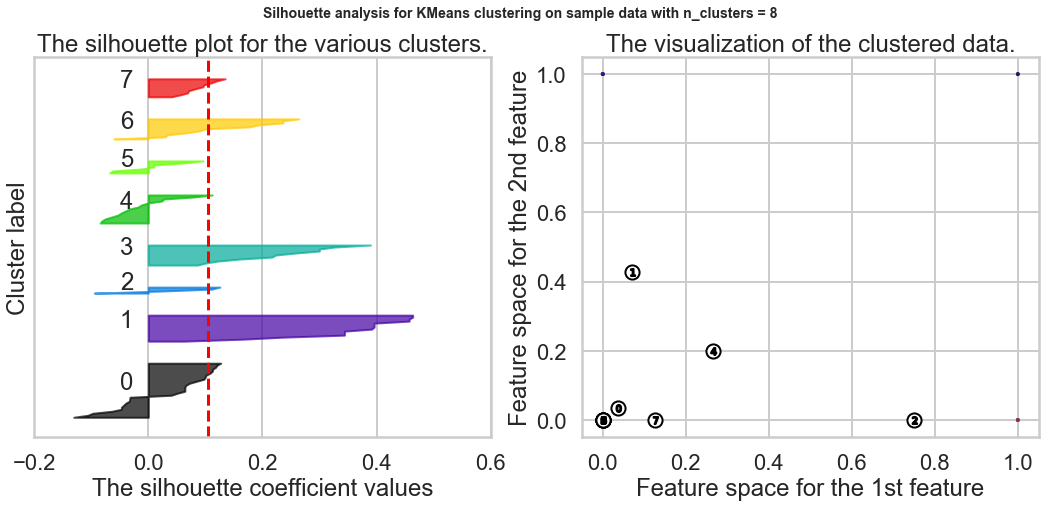

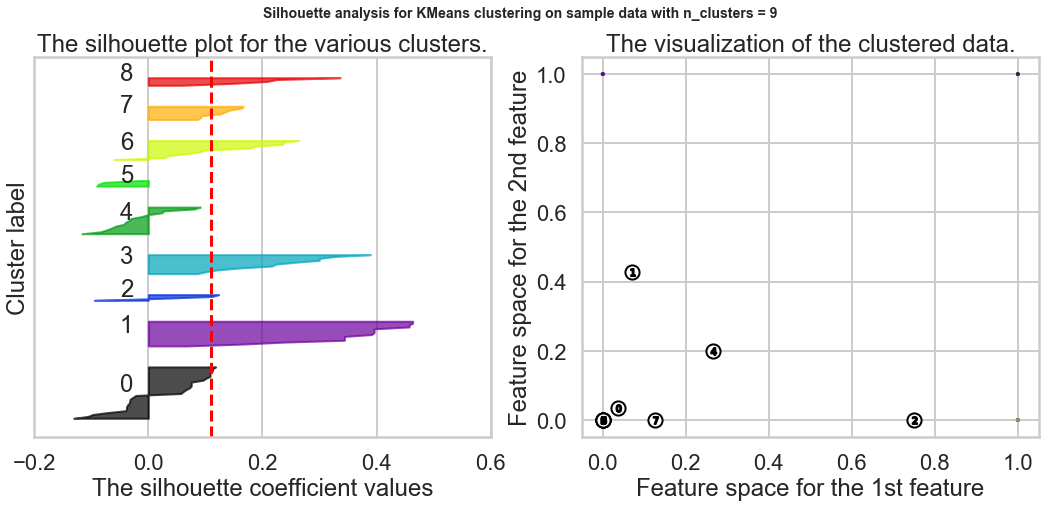

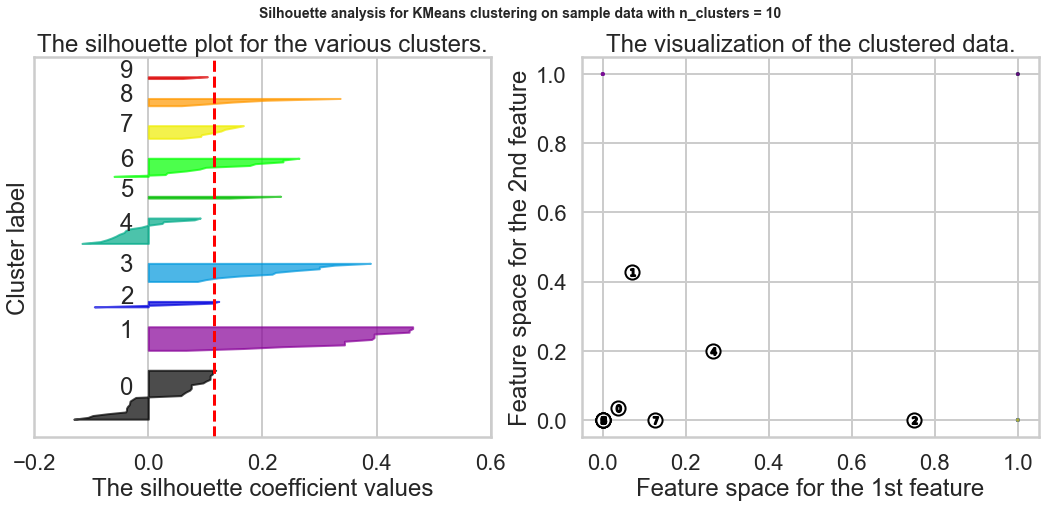

In [338]:
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.cm as cm
import numpy as np

for k in range(2,11):
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.2, 0.6]
    ax1.set_xlim([-0.2, 0.6])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (k + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    kmeans = KMeans(n_clusters=k, random_state=32)
    cluster_labels = kmeans.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", k,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(k):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / k)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.2, 0, 0.2, 0.4, 0.6])

    # 2nd Plot showing the actual clusters formed
    # Note that since our individual instances consist of 0 and 1 we will see our clusters in the extreme 
    # corners of this graph
    colors = cm.nipy_spectral(cluster_labels.astype(float) / k)
    ax2.scatter(X.iloc[:, 0], X.iloc[:, 1], marker='.', s=60, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % k),
                 fontsize=14, fontweight='bold')

plt.show()


I believe the lower values of k tend to produce the cleanest clusters, although for all values of k we end up with instances that are probably assigned to the incorrect cluster.  Generally the clusters don't look great (i.e. silhouette values for each cluster tend to be different from each other, and we get negative silhouette values).  If I had to choose I think a value of k=2 or 3 would be best.  

#### 3aiii.  Choosing $K$: The Gap Statistic

There is one last method worth covering for picking $K$, the so-called Gap statistic. The computation for the gap statistic builds on the sum-of-squares established in the Elbow method discussion, and compares it to the sum-of-squares of a "null distribution," that is, a random set of points with no clustering. The estimate for the optimal number of clusters $K$ is the value for which $\log{SS}$ falls the farthest below that of the reference distribution:

$$G_k = E_n^*\{\log SS_k\} - \log SS_k$$

In other words a good clustering yields a much larger difference between the reference distribution and the clustered data. The reference distribution is a Monte Carlo (randomization) procedure that constructs $B$ random distributions of points within the bounding box (limits) of the original data and then applies K-means to this synthetic distribution of data points.. $E_n^*\{\log SS_k\}$ is just the average $SS_k$ over all $B$ replicates. We then compute the standard deviation $\sigma_{SS}$ of the values of $SS_k$ computed from the $B$ replicates of the reference distribution and compute

$$s_k = \sqrt{1+1/B}\sigma_{SS}$$

Finally, we choose $K=k$ such that $G_k \geq G_{k+1} - s_{k+1}$.

#### Aside: Choosing $K$ when we Have Labels

Unsupervised learning expects that we do not have the labels. In some situations, we may wish to cluster data that is labeled. Computing the optimal number of clusters is much easier if we have access to labels. There are several methods available. We will not go into the math or details since it is rare to have access to the labels, but we provide the names and references of these measures.

* Adjusted Rand Index
* Mutual Information
* V-Measure
* Fowlkes–Mallows index

**Hint:** See [this article](http://scikit-learn.org/stable/modules/clustering.html) for more information about these metrics.

### 3b. Visualizing Clusters using PCA

How do we visualize clusters? If we only had two features, we could likely plot the data as is. But we have 100 data points each containing 32 features (dimensions). Principal Component Analysis (PCA) will help us reduce the dimensionality of our data from 32 to something lower. For a visualization on the coordinate plane, we will use 2 dimensions. In this exercise, we're going to use it to transform our multi-dimensional dataset into a 2 dimensional dataset.

This is only one use of PCA for dimension reduction. We can also use PCA when we want to perform regression but we have a set of highly correlated variables. PCA untangles these correlations into a smaller number of features/predictors all of which are orthogonal (not correlated). PCA is also used to reduce a large set of variables into a much smaller one.

**Hint:** PCA was discussed in the previous subunit. If you need help with it, consult [this useful article](https://towardsdatascience.com/a-one-stop-shop-for-principal-component-analysis-5582fb7e0a9c) and [this visual explanation](http://setosa.io/ev/principal-component-analysis/). 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set IV</h3>

<p><b>Exercise:</b> Use PCA to plot your clusters:</p>

<ul>
<li> Use scikit-learn's [`PCA`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) function to reduce the dimensionality of your clustering data to 2 components
<li> Create a data frame with the following fields:
  <ul>
  <li> customer name
  <li> cluster id the customer belongs to
  <li> the two PCA components (label them `x` and `y`)
  </ul>
<li> Plot a scatterplot of the `x` vs `y` columns
<li> Color-code points differently based on cluster ID
<li> How do the clusters look? 
<li> Based on what you see, what seems to be the best value for $K$? Moreover, which method of choosing $K$ seems to have produced the optimal result visually?
</ul>

<p><b>Exercise:</b> Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?</p>
</div>

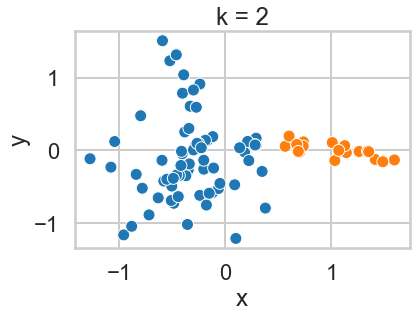

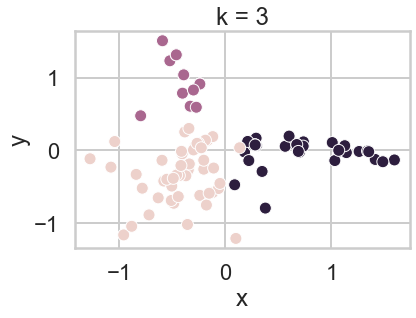

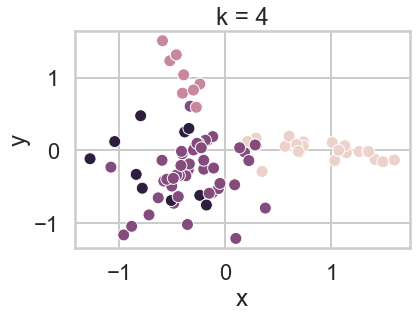

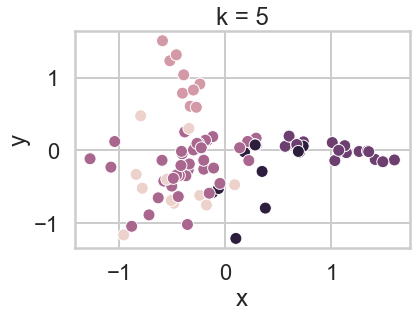

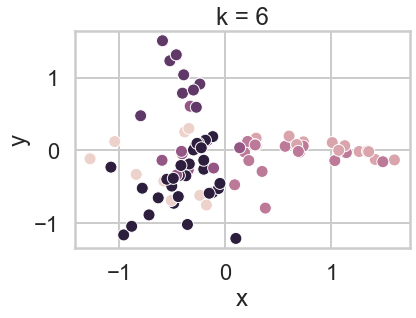

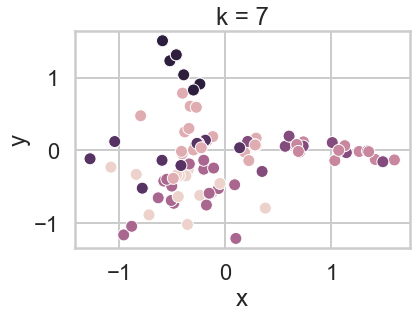

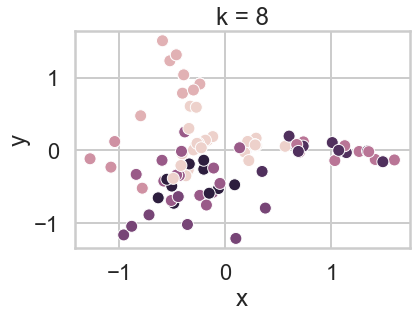

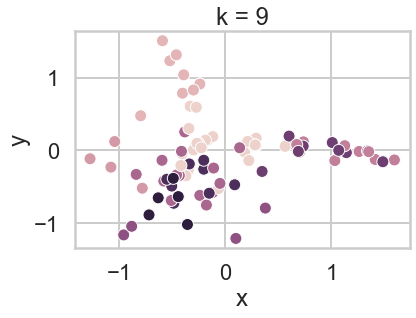

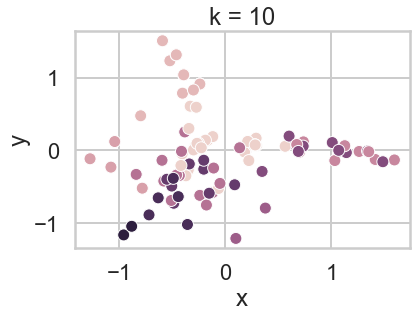

In [381]:
# We're going to create a dataframe with customer name, cluster id (which we'll fill for various values of k), x, and y

df_pca = pd.DataFrame()
df_pca['customer_name']= df_cust_by_offer.index

# Let's add the two dimensions from PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

# Apply the fit_transform method of model to grains: pca_features
pca_features = pca.fit_transform(X)

# Assign these components to x and y columns in our df
df_pca['x'] = pca_features[:,0]
df_pca['y'] = pca_features[:,1]

# Now let's cluster based on various values of k and plot a scatter plot for each value of k

for k in range(2,11):
    kmeans = KMeans(n_clusters=k, random_state=32)
    cluster_labels = kmeans.fit_predict(X)
    df_pca['cluster_labels'] = cluster_labels
    
    # Scatter plot x vs y
    sns.scatterplot(x='x', y='y', data=df_pca, hue=df_pca['cluster_labels'], legend=False) 
    plt.title('k = %d' % k)
    plt.show()

What we've done is we've taken those columns of 0/1 indicator variables, and we've transformed them into a 2-D dataset. We took one column and arbitrarily called it `x` and then called the other `y`. Now we can throw each point into a scatterplot. We color coded each point based on it's cluster so it's easier to see them.

Based on these scatterplots, I would think the optimal number of clusters is either 2 or 3 because for those values of k, we get very defined clusters.  Visually, I think k=3 makes the most sense because we get very defined clusters, but we have enough granularity between them. 

In [398]:
# Let's cluster our data into three clusters and look at the data
kmeans = KMeans(n_clusters=3, random_state=32)
cluster_labels = kmeans.fit_predict(X)
df_pca['cluster_labels'] = cluster_labels

In [399]:
# Let's loop through clusters and look at varietals purchased by customers in each cluster
for i in range(3):
    cust_i = df_pca[df_pca['cluster_labels']==i]['customer_name']
    varietals = df_transactions[df_transactions['customer_name'].isin(cust_i)].merge(df_offers, on='offer_id')['varietal'].value_counts()
    print('Cluster: ',i)
    print('Varietals: ', varietals)

Cluster:  0
Varietals:  Champagne             73
Cabernet Sauvignon    31
Prosecco              19
Malbec                15
Chardonnay            14
Merlot                13
Espumante              8
Pinot Noir             7
Pinot Grigio           1
Name: varietal, dtype: int64
Cluster:  1
Varietals:  Pinot Noir    37
Prosecco       2
Malbec         1
Champagne      1
Merlot         1
Chardonnay     1
Name: varietal, dtype: int64
Cluster:  2
Varietals:  Espumante             32
Prosecco              22
Malbec                16
Pinot Grigio          16
Champagne              7
Merlot                 6
Cabernet Sauvignon     1
Name: varietal, dtype: int64


We can definitely see some patterns here.  I would market Champagne to Cluster 0, and Pinot Noir to Cluster 1, and Espumante to Cluster 2.  Prosecco can be marketed to both Cluster 0 and 2 but not 1.  You definitely see some patterns here.  

In [400]:
# Let's loop through clusters and look at origins purchased by customers in each cluster
for i in range(3):
    cust_i = df_pca[df_pca['cluster_labels']==i]['customer_name']
    origins = df_transactions[df_transactions['customer_name'].isin(cust_i)].merge(df_offers, on='offer_id')['origin'].value_counts()
    print('Cluster: ',i)
    print('Varietals: ', origins)

Cluster:  0
Varietals:  France          86
Chile           30
Italy           12
New Zealand     11
Oregon          11
California       9
Australia        8
South Africa     7
Germany          7
Name: origin, dtype: int64
Cluster:  1
Varietals:  Australia       13
Italy           12
France           7
Germany          7
California       2
New Zealand      1
South Africa     1
Name: origin, dtype: int64
Cluster:  2
Varietals:  France          35
Australia       18
South Africa    17
Oregon          15
Chile            7
California       5
Germany          2
New Zealand      1
Name: origin, dtype: int64


You see some patterns here too.  Clusters 0 and 2 respond to French wines, while Cluster 1 preferes Australian and Italian wines.  I would only market Chilean and New Zealand wines to Cluster 0.  

<div class="span5 alert alert-info">
<h3>Exercise Set V</h3>

<p>As we saw earlier, PCA has a lot of other uses. Since we wanted to visualize our data in 2 dimensions, restricted the number of dimensions to 2 in PCA. But what is the true optimal number of dimensions?</p>

<p><b>Exercise:</b> Using a new PCA object shown in the next cell, plot the `explained_variance_` field and look for the elbow point, the point where the curve's rate of descent seems to slow sharply. This value is one possible value for the optimal number of dimensions. What is it?</p>
</div>

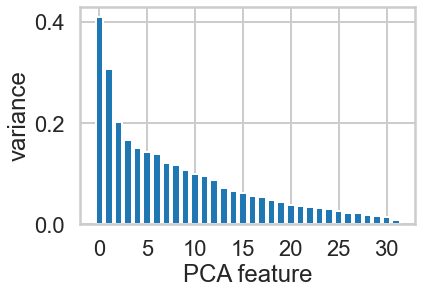

In [375]:
#your turn
# Initialize a new PCA model with a default number of components.
import sklearn.decomposition
pca = sklearn.decomposition.PCA()
pca.fit(X)

features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_)
plt.xlabel('PCA feature')
plt.ylabel('variance')
plt.xticks([0,5,10,15,20,25,30])
plt.show()

We can see pretty clearly here that the intrinsic dimension of the dataset is 2. 

## 4. Conclusions and next steps
### 4a. Conclusions
What can you conclude from your investigations? Make a note, formulate it as clearly as possible, and be prepared to discuss it with your mentor in your next call. 

I would conclude that our datset has an intrinsic dimension of 2, and so plotting the data in the two dimenionsal PCA space allows us to visually see if our clustering is making sense.  From this analysis, it is pretty clear that we can cluster the data into 2 or 3 clusters.  This is very attractive, because we get very defined clusters, and we can clearly see patterns in terms of varietals and countries of origin with these clusters, and so there are clear recommendations we can make to marketing.  In addition, becuase we only have 100 customers, I would be hesitant to fragment them into a very high number of clusters, i.e. we'd just be overfitting in a way.  

### 4b. Other clustering algorithms

k-means is only one of a ton of clustering algorithms. Below is a brief description of several clustering algorithms, and the table provides references to the other clustering algorithms in scikit-learn. 

* **Affinity Propagation** does not require the number of clusters $K$ to be known in advance! AP uses a "message passing" paradigm to cluster points based on their similarity. 

* **Spectral Clustering** uses the eigenvalues of a similarity matrix to reduce the dimensionality of the data before clustering in a lower dimensional space. This is tangentially similar to what we did to visualize k-means clusters using PCA. The number of clusters must be known a priori.

* **Ward's Method** applies to hierarchical clustering. Hierarchical clustering algorithms take a set of data and successively divide the observations into more and more clusters at each layer of the hierarchy. Ward's method is used to determine when two clusters in the hierarchy should be combined into one. It is basically an extension of hierarchical clustering. Hierarchical clustering is *divisive*, that is, all observations are part of the same cluster at first, and at each successive iteration, the clusters are made smaller and smaller. With hierarchical clustering, a hierarchy is constructed, and there is not really the concept of "number of clusters." The number of clusters simply determines how low or how high in the hierarchy we reference and can be determined empirically or by looking at the [dendogram](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html).

* **Agglomerative Clustering** is similar to hierarchical clustering but but is not divisive, it is *agglomerative*. That is, every observation is placed into its own cluster and at each iteration or level or the hierarchy, observations are merged into fewer and fewer clusters until convergence. Similar to hierarchical clustering, the constructed hierarchy contains all possible numbers of clusters and it is up to the analyst to pick the number by reviewing statistics or the dendogram.

* **DBSCAN** is based on point density rather than distance. It groups together points with many nearby neighbors. DBSCAN is one of the most cited algorithms in the literature. It does not require knowing the number of clusters a priori, but does require specifying the neighborhood size.

### Clustering Algorithms in Scikit-learn
<table border="1">
<colgroup>
<col width="15%" />
<col width="16%" />
<col width="20%" />
<col width="27%" />
<col width="22%" />
</colgroup>
<thead valign="bottom">
<tr><th>Method name</th>
<th>Parameters</th>
<th>Scalability</th>
<th>Use Case</th>
<th>Geometry (metric used)</th>
</tr>
</thead>
<tbody valign="top">
<tr><td>K-Means</span></a></td>
<td>number of clusters</td>
<td>Very large<span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span> with
MiniBatch code</td>
<td>General-purpose, even cluster size, flat geometry, not too many clusters</td>
<td>Distances between points</td>
</tr>
<tr><td>Affinity propagation</td>
<td>damping, sample preference</td>
<td>Not scalable with n_samples</td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Mean-shift</td>
<td>bandwidth</td>
<td>Not scalable with <span class="pre">n_samples</span></td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Distances between points</td>
</tr>
<tr><td>Spectral clustering</td>
<td>number of clusters</td>
<td>Medium <span class="pre">n_samples</span>, small <span class="pre">n_clusters</span></td>
<td>Few clusters, even cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Ward hierarchical clustering</td>
<td>number of clusters</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints</td>
<td>Distances between points</td>
</tr>
<tr><td>Agglomerative clustering</td>
<td>number of clusters, linkage type, distance</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints, non Euclidean
distances</td>
<td>Any pairwise distance</td>
</tr>
<tr><td>DBSCAN</td>
<td>neighborhood size</td>
<td>Very large <span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span></td>
<td>Non-flat geometry, uneven cluster sizes</td>
<td>Distances between nearest points</td>
</tr>
<tr><td>Gaussian mixtures</td>
<td>many</td>
<td>Not scalable</td>
<td>Flat geometry, good for density estimation</td>
<td>Mahalanobis distances to  centers</td>
</tr>
<tr><td>Birch</td>
<td>branching factor, threshold, optional global clusterer.</td>
<td>Large <span class="pre">n_clusters</span> and <span class="pre">n_samples</span></td>
<td>Large dataset, outlier removal, data reduction.</td>
<td>Euclidean distance between points</td>
</tr>
</tbody>
</table>
Source: http://scikit-learn.org/stable/modules/clustering.html

<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Try clustering using the following algorithms. </p>
<ol>
<li>Affinity propagation
<li>Spectral clustering
<li>Agglomerative clustering
<li>DBSCAN
</ol>
<p>How do their results compare? Which performs the best? Tell a story why you think it performs the best.</p>
</div>


What we'll do is cluster with each of these algorithms, and then compare them in our 2-dimensional PCA space.  

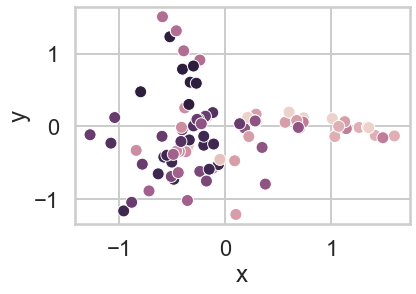

In [402]:
# Affinity propagation
from sklearn.cluster import AffinityPropagation
clusterer = AffinityPropagation(random_state=32)
df_pca['cluster_labels'] = clusterer.fit_predict(X)

# Scatter plot x vs y
sns.scatterplot(x='x', y='y', data=df_pca, hue=df_pca['cluster_labels'], legend=False) 
plt.show()

In [403]:
df_pca['cluster_labels'].nunique()

14

So we can that this produced 14 clusters.  From our previous analysis, I believe this is too fragmented for our dataset.  We can see in our two-dimensional space that the clusters are not clearly defined.  

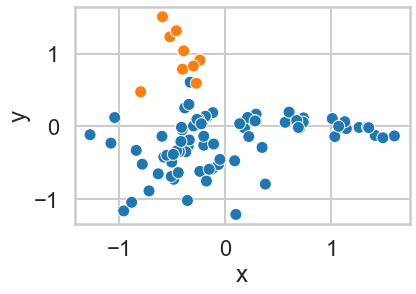

In [397]:
# Spectral clustering
from sklearn.cluster import SpectralClustering
clusterer = SpectralClustering(n_clusters = 2, random_state=32)
df_pca['cluster_labels'] = clusterer.fit_predict(X)

# Scatter plot x vs y
sns.scatterplot(x='x', y='y', data=df_pca, hue=df_pca['cluster_labels'], legend=False) 
plt.show()

This is interesting.  Even though we chose two clusters, the clusters it produced are different than the two clusters we got for KMeans.  Let's try again with three clusters.

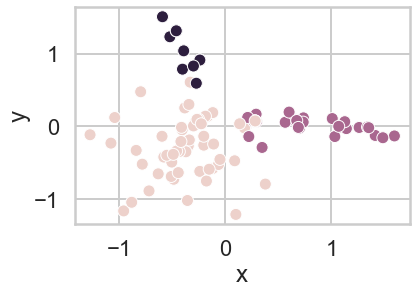

In [404]:
# Spectral clustering
from sklearn.cluster import SpectralClustering
clusterer = SpectralClustering(n_clusters = 3, random_state=32)
df_pca['cluster_labels'] = clusterer.fit_predict(X)

# Scatter plot x vs y
sns.scatterplot(x='x', y='y', data=df_pca, hue=df_pca['cluster_labels'], legend=False) 
plt.show()

Now this matches our clusters for KMeans.  We get nice clearly defined clusters.  

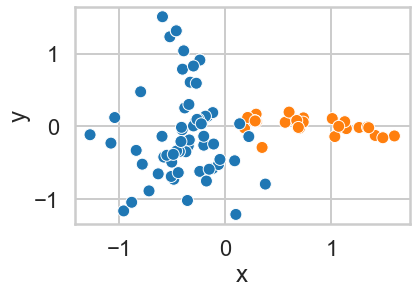

In [406]:
# Agglomerative Clustering
from sklearn.cluster import AgglomerativeClustering
clusterer = AgglomerativeClustering(n_clusters = 2)
df_pca['cluster_labels'] = clusterer.fit_predict(X)

# Scatter plot x vs y
sns.scatterplot(x='x', y='y', data=df_pca, hue=df_pca['cluster_labels'], legend=False) 
plt.show()

This matches our KMeans clustering which is not surprising because it's a natural way to split the data.   

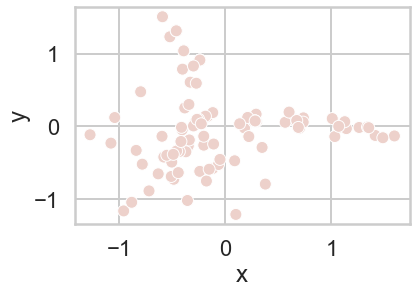

In [407]:
# DBSCAN
from sklearn.cluster import DBSCAN
clusterer = DBSCAN()
df_pca['cluster_labels'] = clusterer.fit_predict(X)

# Scatter plot x vs y
sns.scatterplot(x='x', y='y', data=df_pca, hue=df_pca['cluster_labels'], legend=False) 
plt.show()

In [408]:
df_pca['cluster_labels'].nunique()

1

Interesting, we got only one cluster.  Let's try this again with a different value for epsilon.  

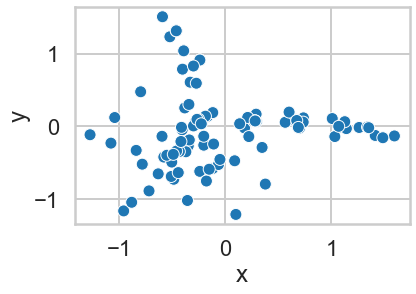

In [409]:
# DBSCAN
from sklearn.cluster import DBSCAN
clusterer = DBSCAN(eps=10)
df_pca['cluster_labels'] = clusterer.fit_predict(X)

# Scatter plot x vs y
sns.scatterplot(x='x', y='y', data=df_pca, hue=df_pca['cluster_labels'], legend=False) 
plt.show()

In [410]:
df_pca['cluster_labels'].nunique()

1

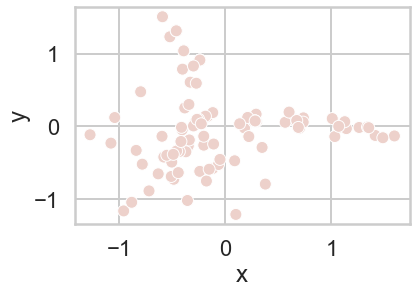

In [413]:
# DBSCAN
from sklearn.cluster import DBSCAN
clusterer = DBSCAN(eps=.01)
df_pca['cluster_labels'] = clusterer.fit_predict(X)

# Scatter plot x vs y
sns.scatterplot(x='x', y='y', data=df_pca, hue=df_pca['cluster_labels'], legend=False) 
plt.show()

Interesting, I've tried values of episolon from .01 to 100 and still only get one cluster. 